# Set seed

In [5]:
import random
import numpy as np
# import torch

# Set a fixed seed value
seed = 98

# Python, NumPy, and PyTorch (CPU)
random.seed(seed)
np.random.seed(seed)
# torch.manual_seed(seed)

rng = np.random.default_rng(seed)

# # Only set CUDA seeds if a GPU is available
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# print(f"Seeds set to {seed} (with CUDA: {torch.cuda.is_available()})")

# Simulate DNA segments

In [6]:
from __future__ import annotations
import math
from dataclasses import dataclass
from typing import List
import csv

@dataclass
class WLCParams:
    bp: int
    nm_per_bp: float
    lp_nm: float
    D_nm: float
    ds_nm: float
    n_chains: int
    seed: int

def rotate_tangent(t: np.ndarray, ds: float, lp: float, rng: np.random.Generator) -> np.ndarray:
    """
    Rotate unit tangent t by a small random angle on the unit sphere.
    For WLC in 3D: Var(theta) = 2 ds / lp.
    """
    # Build an orthonormal basis {e1, e2, t}
    a = np.array([1.0, 0.0, 0.0])
    if abs(np.dot(a, t)) > 0.9:
        a = np.array([0.0, 1.0, 0.0])
    e1 = a - np.dot(a, t) * t
    e1 /= np.linalg.norm(e1)
    e2 = np.cross(t, e1)

    # Random 2D Gaussian in the perpendicular plane
    sigma = math.sqrt(2.0 * ds / lp)
    xi1, xi2 = rng.normal(size=2)
    dvec = sigma * (xi1 * e1 + xi2 * e2)
    dtheta = np.linalg.norm(dvec)
    if dtheta < 1e-12:
        return t.copy()
    k = dvec / dtheta

    # Rodrigues formula
    t_new = t * math.cos(dtheta) + np.cross(k, t) * math.sin(dtheta)
    return t_new / np.linalg.norm(t_new)


def reflect_at_plane(t: np.ndarray, normal: np.ndarray) -> np.ndarray:
    """Specular reflection of tangent across a plane with given unit normal."""
    return t - 2.0 * np.dot(t, normal) * normal


def propagate_step(r: np.ndarray, t: np.ndarray, ds: float, D: float) -> tuple[np.ndarray, np.ndarray]:
    """
    Propagate by ds with reflections at channel walls.
    Channel axis: y (infinite).
    Confinement: 0 <= x <= D, 0 <= z <= D.
    """
    remaining = ds
    x, y, z = r
    tx, ty, tz = t

    while remaining > 0:
        hits = []
        # x walls
        if tx > 0: hits.append(((D - x) / tx, np.array([-1.0, 0.0, 0.0])))  # hit x=D
        if tx < 0: hits.append(((0.0 - x) / tx, np.array([ 1.0, 0.0, 0.0])))  # hit x=0
        # z walls
        if tz > 0: hits.append(((D - z) / tz, np.array([0.0, 0.0, -1.0])))   # hit z=D
        if tz < 0: hits.append(((0.0 - z) / tz, np.array([0.0, 0.0,  1.0]))) # hit z=0

        hits = [(d, n) for (d, n) in hits if d > 0]

        if not hits:
            # move full step
            x += remaining * tx; y += remaining * ty; z += remaining * tz
            remaining = 0.0
            break

        dmin, normal = min(hits, key=lambda p: p[0])

        if dmin >= remaining:
            x += remaining * tx; y += remaining * ty; z += remaining * tz
            remaining = 0.0
        else:
            # hit a wall
            x += dmin * tx; y += dmin * ty; z += dmin * tz
            remaining -= dmin
            # snap
            if normal[0] != 0:
                x = 0.0 if normal[0] > 0 else D
            if normal[2] != 0:
                z = 0.0 if normal[2] > 0 else D
            # reflect tangent
            t_vec = np.array([tx, ty, tz], dtype=float)
            t_vec = reflect_at_plane(t_vec, normal)
            t_vec /= np.linalg.norm(t_vec)
            tx, ty, tz = t_vec

    return np.array([x, y, z]), np.array([tx, ty, tz])


def simulate_chain(L_nm=306.0, ds_nm=0.2, lp_nm=50.0, D_nm=100.0, rng=None):
    """
    Simulate one WLC chain of contour length L_nm inside a square nanochannel
    of width D_nm along x,z. Axis is along y.
    """
    if rng is None:
        rng = np.random.default_rng(7)
    n_steps = int(round(L_nm / ds_nm))

    # start at y=0, random x,z inside channel; tangent along +y
    r = np.array([rng.uniform(0.0, D_nm), 0.0, rng.uniform(0.0, D_nm)], dtype=float)
    t = np.array([0.0, 1.0, 0.0], dtype=float)

    coords = np.empty((n_steps + 1, 3), dtype=float)
    coords[0] = r

    for i in range(n_steps):
        t = rotate_tangent(t, ds_nm, lp_nm, rng)
        r, t = propagate_step(r, t, ds_nm, D_nm)
        coords[i + 1] = r

    return coords



def end_to_end(coords: np.ndarray) -> float:
    return float(np.linalg.norm(coords[-1] - coords[0]))


def radius_of_gyration(coords: np.ndarray) -> float:
    cm = coords.mean(axis=0)
    return float(np.sqrt(((coords - cm) ** 2).sum(axis=1).mean()))


def simulate_many(params: WLCParams) -> List[np.ndarray]:
    """Run n_chains independent simulations."""
    rng = np.random.default_rng(params.seed)
    L_nm = params.bp * params.nm_per_bp
    chains: List[np.ndarray] = []
    for _ in range(params.n_chains):
        chains.append(simulate_chain(L_nm, params.ds_nm, params.lp_nm, params.D_nm, rng))
    return chains


def save_to_csv(chains: List[np.ndarray], ds_nm: float, out_path: str) -> None:
    """Save all coordinates to one CSV with columns: chain_id, s_nm, x_nm, y_nm, z_nm"""
    with open(out_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["chain_id", "s_nm", "x_nm", "y_nm", "z_nm"])
        for cid, coords in enumerate(chains):
            for i, (x, y, z) in enumerate(coords):
                writer.writerow([cid, i * ds_nm, x, y, z])


def main() -> None:
    params = WLCParams(
        bp=900,
        nm_per_bp=0.34,
        lp_nm=50.0,
        D_nm=20.0,     # <-- channel width (nm)
        ds_nm=1.0,
        n_chains=5,
        seed=seed,
    )

    # Simulate
    chains = simulate_many(params)

    # Quick summary
    e2e = [end_to_end(c) for c in chains]
    rg = [radius_of_gyration(c) for c in chains]
    print(f"Simulated {len(chains)} chains. ds = {params.ds_nm} nm, D = {params.D_nm} nm")
    print(f"End-to-end distance (nm): mean={np.mean(e2e):.2f}, std={np.std(e2e):.2f}")
    print(f"Radius of gyration (nm):  mean={np.mean(rg):.2f}, std={np.std(rg):.2f}")

    # Save coordinates
    out_csv = "dna_900bp_channel_WLC_D20.csv"
    save_to_csv(chains, params.ds_nm, out_csv)
    print(f"Saved coordinates to {out_csv}")


if __name__ == "__main__":
    main()


Simulated 5 chains. ds = 1.0 nm, D = 20.0 nm
End-to-end distance (nm): mean=66.43, std=28.64
Radius of gyration (nm):  mean=23.75, std=13.16
Saved coordinates to dna_900bp_channel_WLC_D20.csv


## align segments

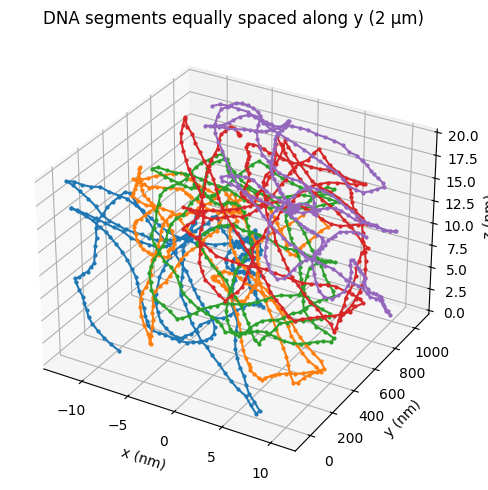

<Axes: title={'center': 'Projection: z–y'}, xlabel='x (nm)', ylabel='y (nm)'>

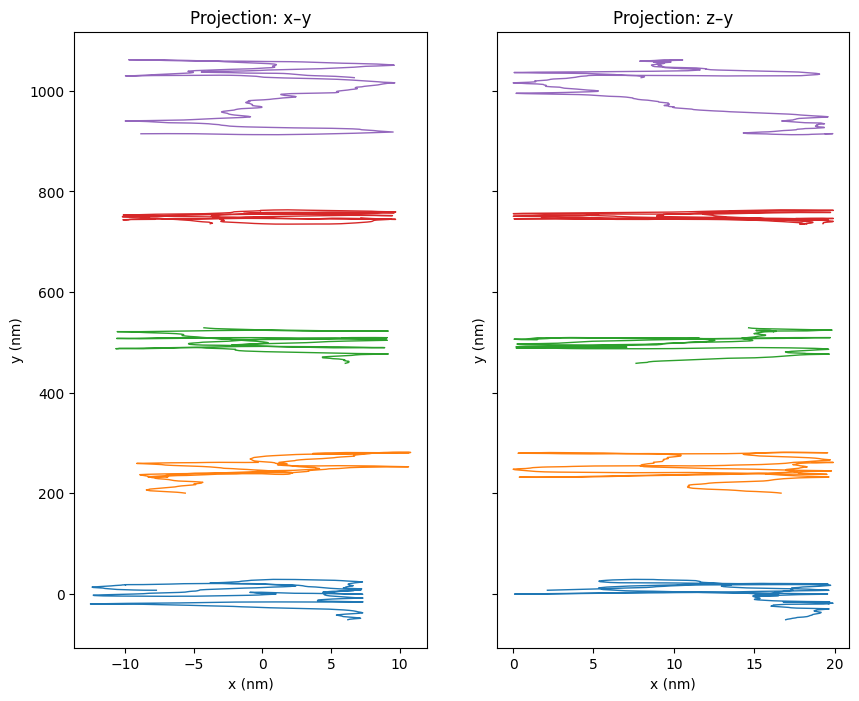

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load DNA chains
df = pd.read_csv("dna_900bp_channel_WLC_D20.csv")

chain_ids = df["chain_id"].unique()[:5]
segments = []

# Step 1: Align x to center of mass for each segment
for cid in chain_ids:
    coords = df[df["chain_id"] == cid][["x_nm", "y_nm", "z_nm"]].to_numpy()
    com_x = coords[:, 0].mean()
    coords[:, 0] -= com_x  # shift x to COM
    segments.append(coords)

# Step 2: Place them equally spaced in y
L_total = 1000.0  # approx end to end distance
n_segments = len(segments)
y_positions = np.linspace(0, L_total, n_segments)  # target COM y for each segment

aligned_segments = []
for seg, y_target in zip(segments, y_positions):
    seg_copy = seg.copy()
    com_y = seg_copy[:, 1].mean()
    shift_y = y_target - com_y
    seg_copy[:, 1] += shift_y
    aligned_segments.append(seg_copy)

# Step 3: Set minimum z = 0
all_coords = np.vstack(aligned_segments)
z_min = all_coords[:, 2].min()
for seg in aligned_segments:
    seg[:, 2] -= z_min
all_coords[:, 2] -= z_min

# --- Plot result ---
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")

for seg in aligned_segments:
    ax.plot(seg[:, 0], seg[:, 1], seg[:, 2], "-o", ms=2)
ax.set_xlabel("x (nm)")
ax.set_ylabel("y (nm)")
ax.set_zlabel("z (nm)")
ax.set_title("DNA segments equally spaced along y (2 µm)")

plt.tight_layout()
plt.show()

# 2D projections with y vertical
fig, axes = plt.subplots(1, 2, figsize=(10, 8), sharey=True)

# x–y projection (y vertical)
for seg in aligned_segments:
    axes[0].plot(seg[:, 0], seg[:, 1], linewidth=1.0)
axes[0].set_xlabel("x (nm)")
axes[0].set_ylabel("y (nm)")
axes[0].set_title("Projection: x–y")
axes[0]

# z–y projection (y vertical)
for seg in aligned_segments:
    axes[1].plot(seg[:, 2], seg[:, 1], linewidth=1.0)
axes[1].set_xlabel("x (nm)")
axes[1].set_ylabel("y (nm)")
axes[1].set_title("Projection: z–y")
axes[1]


# Sample fluorophores positions

Group 1: 37 positions, COM = [ 0.02632825 -0.52452679 13.55499089]
Group 2: 196 positions, COM = [-2.01122950e-02  2.49944036e+02  1.20972280e+01]
Group 3: 184 positions, COM = [-3.46044168e-02  4.99988575e+02  1.05833401e+01]
Group 4: 194 positions, COM = [-1.31472542e-02  7.49980343e+02  1.13156956e+01]
Group 5: 194 positions, COM = [-3.77584138e-03  9.99958048e+02  1.05272299e+01]


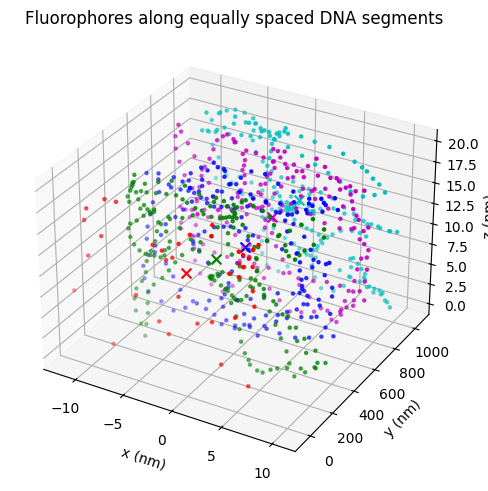

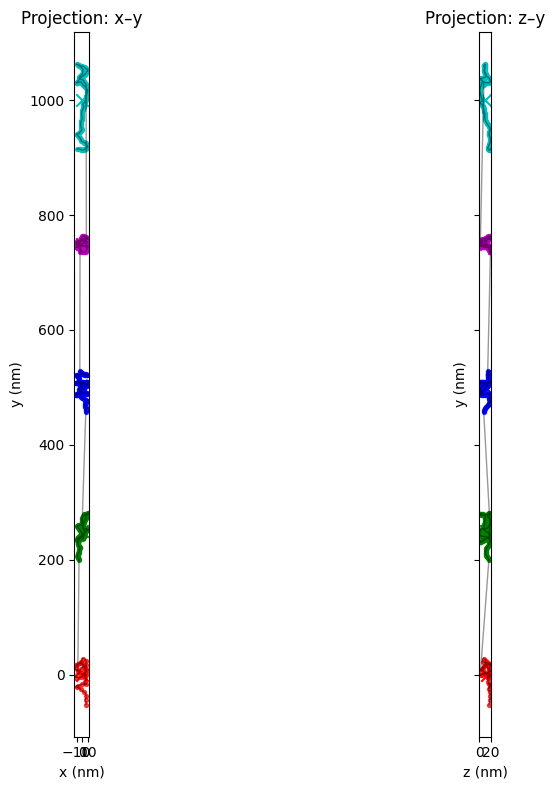

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load DNA chains ---
df = pd.read_csv("dna_900bp_channel_WLC_D20.csv")
chain_ids = df["chain_id"].unique()[:5]
segments = []

# Step 1: Align x to center of mass for each chain
for cid in chain_ids:
    coords = df[df["chain_id"] == cid][["x_nm", "y_nm", "z_nm"]].to_numpy()
    com_x = coords[:, 0].mean()
    coords[:, 0] -= com_x
    segments.append(coords)

# Step 2: Place equally spaced along y
L_total = 1000.0  # approx end to end distance
n_segments = len(segments)
y_targets = np.linspace(0, L_total, n_segments)

aligned_segments = []
for seg, y_target in zip(segments, y_targets):
    seg_copy = seg.copy()
    com_y = seg_copy[:, 1].mean()
    seg_copy[:, 1] += y_target - com_y
    aligned_segments.append(seg_copy)

# Step 3: Set minimum z = 0
all_coords = np.vstack(aligned_segments)
z_min = all_coords[:, 2].min()
for seg in aligned_segments:
    seg[:, 2] -= z_min
all_coords[:, 2] -= z_min

# --- Sampling function ---
def sample_positions(segment: np.ndarray, n_samples: int) -> np.ndarray:
    """Sample n_samples positions along a polyline (linear interp)."""
    diffs = np.diff(segment, axis=0)
    seg_lengths = np.linalg.norm(diffs, axis=1)
    cumlen = np.insert(np.cumsum(seg_lengths), 0, 0)
    total_len = cumlen[-1]

    sample_s = np.linspace(0, total_len, n_samples)
    sampled = []
    for s in sample_s:
        idx = np.searchsorted(cumlen, s) - 1
        idx = min(max(idx, 0), len(diffs) - 1)
        t = (s - cumlen[idx]) / seg_lengths[idx] if seg_lengths[idx] > 0 else 0
        point = (1 - t) * segment[idx] + t * segment[idx + 1]
        sampled.append(point)
    return np.array(sampled)

# --- Sample fluorophores ---
rng = np.random.default_rng()
fluorophore_groups = []
group_coms = []

for seg in aligned_segments:
    n = rng.integers(30, 201)  # [30, 200]
    samples = sample_positions(seg, n)
    fluorophore_groups.append(samples)
    group_coms.append(samples.mean(axis=0))

# --- Print group info ---
for i, com in enumerate(group_coms, 1):
    print(f"Group {i}: {len(fluorophore_groups[i-1])} positions, COM = {com}")

# --- 3D plot ---
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")

colors = ["r", "g", "b", "m", "c"]
for samples, com, col in zip(fluorophore_groups, group_coms, colors):
    ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], s=5, color=col)
    ax.scatter(*com, s=50, color=col, marker="x")

ax.set_xlabel("x (nm)")
ax.set_ylabel("y (nm)")
ax.set_zlabel("z (nm)")
ax.set_title("Fluorophores along equally spaced DNA segments")
plt.tight_layout()
plt.show()

# --- 2D projections ---
fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharey=True)

# x–y projection
axes[0].plot(all_coords[:, 0], all_coords[:, 1], "k-", linewidth=1.0, alpha=0.4)
for samples, com, col in zip(fluorophore_groups, group_coms, colors):
    axes[0].scatter(samples[:, 0], samples[:, 1], s=8, color=col, alpha=0.7)
    axes[0].scatter(com[0], com[1], s=80, color=col, marker="x")
axes[0].set_xlabel("x (nm)")
axes[0].set_ylabel("y (nm)")
axes[0].set_title("Projection: x–y")
axes[0].set_aspect("equal", adjustable="box")

# z–y projection
axes[1].plot(all_coords[:, 2], all_coords[:, 1], "k-", linewidth=1.0, alpha=0.4)
for samples, com, col in zip(fluorophore_groups, group_coms, colors):
    axes[1].scatter(samples[:, 2], samples[:, 1], s=8, color=col, alpha=0.7)
    axes[1].scatter(com[2], com[1], s=80, color=col, marker="x")
axes[1].set_xlabel("z (nm)")
axes[1].set_ylabel("y (nm)")
axes[1].set_title("Projection: z–y")
axes[1].set_aspect("equal", adjustable="box")

plt.tight_layout()
plt.show()


# Define Prism

In [11]:
import numpy as np
import deeptrack as dt

def n_bk7_sellmeier(lam_nm: float) -> float:
    lam_um = lam_nm / 1000.0
    B1, B2, B3 = 1.03961212, 0.231792344, 1.01046945
    C1, C2, C3 = 6.00069867e-3, 2.00179144e-2, 1.03560653e2
    lam2 = lam_um**2
    return np.sqrt(1 + (B1*lam2)/(lam2-C1) + (B2*lam2)/(lam2-C2) + (B3*lam2)/(lam2-C3))

class PrismPupilPhase(dt.Feature):
    # Make the feature map over lists of inputs (one pupil per z-slice)
    __distributed__ = True

    def __init__(self, apex_angle_deg=5, direction="x", tube_lens=180*1E-3, 
        lambda0=450*1E-9, **kwargs):
        super().__init__(**kwargs)
        self.apex_angle = np.deg2rad(apex_angle_deg)
        self.direction = direction
        self.f_tube_nm = tube_lens * 1e9  # m → nm
        self.lambda0_nm = lambda0 * 1e9

    @staticmethod
    def _to_nm(val) -> float:
        try:
            return float(val.to("nanometer").magnitude)  # pint Quantity
        except AttributeError:
            return float(val)

    def _theta(self, lam_nm: float) -> float:
        n = n_bk7_sellmeier(lam_nm)
        return (n - 1.0) * self.apex_angle

    def _apply_once(self, pupil, lam_nm, resolution_nm, magnification, factor):
        # Shift at camera in pixels (camera resolution & magnification)
        eff_nm_per_px = resolution_nm / max(1.0, float(magnification))
        theta = self._theta(lam_nm)
        theta0 = self._theta(self.lambda0_nm)
        dtheta = theta - theta0
        
        # # Build linear phase ramp on normalized (-1..1 across pupil)
        H, W = pupil.shape
        
        shift_px = factor * (self.f_tube_nm * dtheta) / eff_nm_per_px
        u = (np.arange(W) - W/2) / (W/2)
        v = (np.arange(H) - H/2) / (H/2)
        U, V = np.meshgrid(u, v)
        axis = U if self.direction == "x" else V
        phase = -2 * np.pi * shift_px  * axis
        ramp = np.exp(1j * phase)

        # kx = (np.fft.fftfreq(W, d=eff_nm_per_px))  # cycles per nm
        # ky = (np.fft.fftfreq(H, d=eff_nm_per_px))
        # KX, KY = np.meshgrid(kx, ky)
        # axis = KX if self.direction == "x" else KY
        # phase = -2 * np.pi *  factor * (self.f_tube_nm * theta) * axis
        # ramp = np.exp(1j * phase)

        out = pupil * ramp  # ✅ multiply: keep defocus & base pupil
        if isinstance(pupil, dt.Image):
            out_img = dt.Image(out, copy=False)
            out_img.properties = pupil.properties
            return out_img
        return out

    def get(self, pupil_function, **kwargs):
        # Read physical parameters
        lam_nm        = kwargs["wavelength"]*1E9
        resolution_nm = kwargs["resolution"]*1E9
        magnification = kwargs.get("magnification", 1)
        factor = kwargs.get("upscale", 1.0)

        # Handle single pupil or list of pupils (one per z-slice)
        if isinstance(pupil_function, list):
            return [self._apply_once(pf, lam_nm, resolution_nm, magnification, factor)
                    for pf in pupil_function]
        else:
            return self._apply_once(pupil_function, lam_nm, resolution_nm, magnification, factor)





# Simulate images

In [15]:
import deeptrack as dt
import matplotlib.pyplot as plt
import numpy as np

pixel_size = 86.0 * 1E-9  # m
im_size = 128
center = [im_size // 2, im_size // 2, 0]


# Example spectrum and corresponding fluorophore groups
spectrum = [480.0*1E-9, 500.0*1E-9, 640.0*1E-9, 560.0*1E-9, 500.0*1E-9]  # nm
assert len(spectrum) == len(fluorophore_groups), "Need ≥ as many groups as wavelengths"

particles = []
segment_spots = []
for group, com in zip(fluorophore_groups, group_coms):
    particle = dt.PointParticle(
        all_coords=2*group / (pixel_size * 1E9)+ [2*center[0], 2*center[1], 0],
        replicate_index=lambda _ID: _ID,
        coords=lambda replicate_index, all_coords: all_coords[replicate_index],
        position=lambda coords: coords[[1, 0]],
        position_unit='pixel',
        z=lambda coords: coords[2] * pixel_size,
        number_of_particles=group.shape[0],
        intensity=lambda number_of_particles: np.random.uniform(10, 100, size=number_of_particles),
    )
    particles.append(particle)

    segment_spot = dt.PointParticle(
        coords=2*com/(pixel_size * 1E9) + [2*center[0], 2*center[1], 0],
        position=lambda coords: coords[[1, 0]],
        position_unit='pixel',
        z=0 * 1E-9,#lambda coords: 100 * coords[2] * pixel_size * dt.units.nm,
        intensity = 1E2,
    )
    segment_spots.append(segment_spot)

# Pair each particle group with a specific wavelength
image = sum([
    dt.Fluorescence(
        NA=1.42,
        wavelength=wl,
        medium_refractive_index=1.33,
        resolution=pixel_size,
        output_region=[0, 0, 2*im_size, 2*im_size],
        magnification=2,
         pupil=PrismPupilPhase(
            apex_angle_deg=1,
            direction="x",
            tube_lens=5E-3,
            wavelength=wl,
            resolution = pixel_size,
            magnification = 2,
        ),
    )(p ^ p.number_of_particles)
    for wl, p in zip(spectrum, particles)
])


mask = sum([dt.Fluorescence(
                NA=3,
                wavelength=spectrum[0], # this is fixed on purpose
                medium_refractive_index=1.33,
                resolution=pixel_size,
                output_region=[0, 0, 2*im_size, 2*im_size],
                magnification=2,
                pupil=PrismPupilPhase(
                    apex_angle_deg=1,
                    direction="x",
                    tube_lens = 5E-3, 
                    wavelength=wl,  
                    resolution = pixel_size,
                    magnification = 2,
                ),
            )(m)  >> dt.NormalizeMinMax(0,1)
    for wl, m in zip(spectrum, segment_spots)
])

# Add noise if desired
image = image >> dt.AveragePooling(size=(2, 2)) >> dt.Add(100) >> dt.Poisson(snr=1E3) #
pipeline = image & mask


# Resolve into array
sim, gt = pipeline()



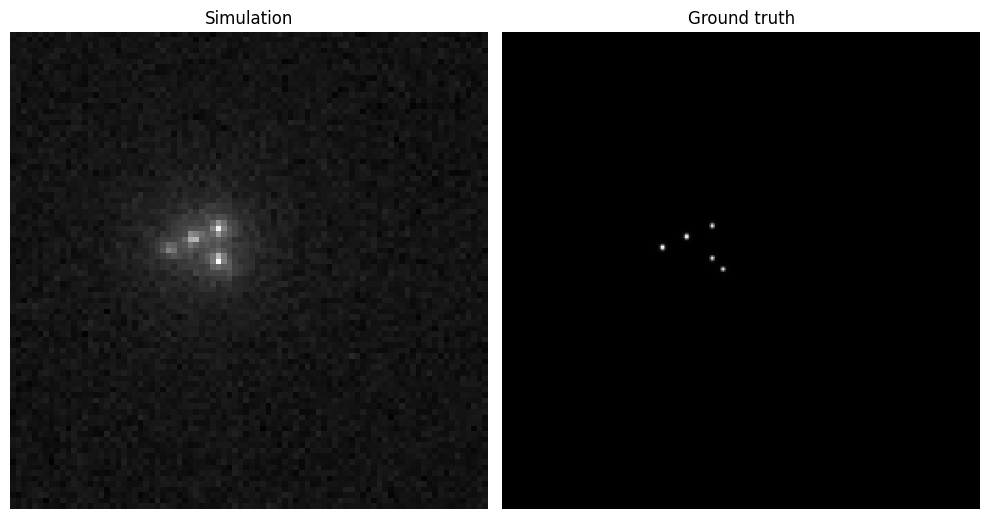

In [16]:
import matplotlib.pyplot as plt

# Force both images to span the same coordinate system
extent = [0, 1, 0, 1]   # normalized box [0,1] in x and y

fig, axes = plt.subplots(1, 2, figsize=(10, 8), sharey=True)

axes[0].imshow(sim, cmap="gray", extent=extent, origin="lower")
axes[0].set_title("Simulation")
axes[0].axis("off")

axes[1].imshow(gt, cmap="gray", extent=extent, origin="lower")
axes[1].set_title("Ground truth")
axes[1].axis("off")

plt.tight_layout()
plt.show()



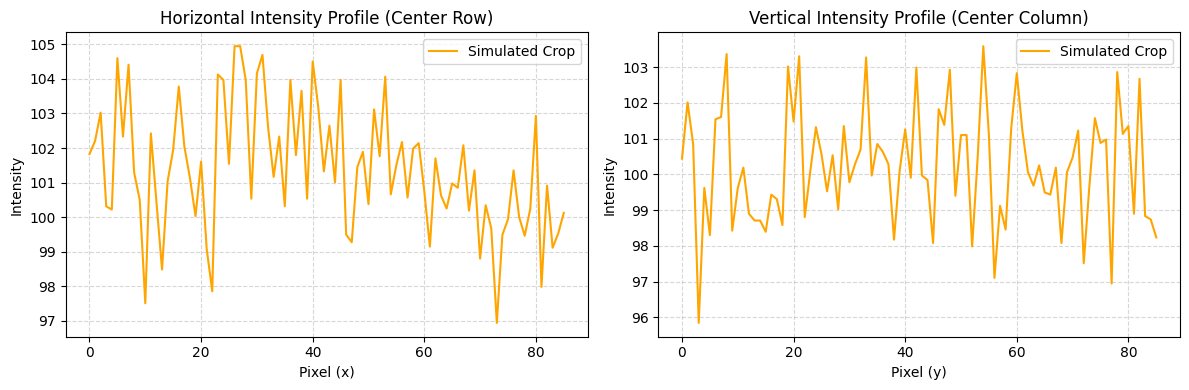

In [17]:
# Extract horizontal (row) profiles.
sim_horiz = sim[center[0], :]

# Extract vertical (column) profiles.
sim_vert = sim[:, center[1]]

# Create a 1×2 subplot.
fig, axes = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)

# --- Horizontal profile ---
axes[0].plot(sim_horiz, label="Simulated Crop", color="orange")
axes[0].set_xlabel("Pixel (x)")
axes[0].set_ylabel("Intensity")
axes[0].set_title("Horizontal Intensity Profile (Center Row)")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.5)

# --- Vertical profile ---
axes[1].plot(sim_vert, label="Simulated Crop", color="orange")
axes[1].set_xlabel("Pixel (y)")
axes[1].set_ylabel("Intensity")
axes[1].set_title("Vertical Intensity Profile (Center Column)")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.5)